In [1]:
#| default_exp nb_03

# Why do we use sqrt5?
> Exploring initialization parameters in PyTorch

## Does `nn.Conv2d` init work well?

In `torch.nn.modules.conv`'s `reset_parameters` function (the initialization function), `init.kaiming_uniform_` is used (what we learned last lecture) with the following setting:

```python
def reset_parameters(self):
    ...
    init.kaiming_uniform_(self.weight, a=math.sqrt(5))
    ...
```

This `a` is undocumented.

In [13]:
#| export
from pathlib import Path
import gzip, pickle
from torch import tensor
from functools import partial
import math
from coursenotes.nb_01 import MNIST_URL
from fastdownload import FastDownload
from coursenotes.nb_02 import mse

DATA_PATH = Path("~/.fastai/data/")

def get_data():
    fd = FastDownload(base="~/.fastai")
    path = fd.download(MNIST_URL)
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))

def normalize(x, mean, std): return (x-mean)/std

In [15]:
x_train, y_train, x_valid, y_valid = get_data()
train_mean, train_std = x_train.mean(), x_train.std()
# Use functools.partial here to make it a bit more efficient
norm = partial(normalize, mean=train_mean, std=train_std)
x_train = norm(x_train)
x_valid = norm(x_valid)

In [16]:
x_train = x_train.view(-1,1,28,28)
x_valid = x_valid.view(-1,1,28,28)
x_train.shape, x_valid.shape

(torch.Size([50000, 1, 28, 28]), torch.Size([10000, 1, 28, 28]))

To do a convolution we need a square or rectangular shape, which is why the data is now `batch_size, n_channels, width, height`

In [17]:
num_datapoints,*_ = x_train.shape
num_classes = y_train.max()+1
num_hidden = 32
num_datapoints, num_classes

(50000, tensor(10))

#| explain num_datapoints,* = x_train.shape
This is some python code that will only keep the first out of a tuple and forgo the rest

#| explain num_classes = 
Get the number of classes

#| explain num_hidden
The size of our hidden layer

In [19]:
from torch import nn

Now we'll create a simple `nn.Conv2d` layer that expects a single-channel input, the size of the hidden layer, and we'll make it a 5x5 kernel (more on this later):

In [20]:
l1 = nn.Conv2d(1, num_hidden, 5)

In [21]:
x = x_valid[:100] # Get a subset of our data

In [22]:
x.shape

torch.Size([100, 1, 28, 28])

In [23]:
def stats(x:tensor):
    "Return the mean and std of x"
    return x.mean(), x.std()

In [24]:
l1.weight.shape

torch.Size([32, 1, 5, 5])

- 32: output shape
- 1: one input filter/channel
- 5x5: the kernel shape

In [25]:
stats(l1.weight), stats(l1.bias)

((tensor(0.0003, grad_fn=<MeanBackward0>),
  tensor(0.1143, grad_fn=<StdBackward0>)),
 (tensor(0.0509, grad_fn=<MeanBackward0>),
  tensor(0.1009, grad_fn=<StdBackward0>)))

In [26]:
t = l1(x)

In [27]:
stats(t) # want this to be as close to a mean of 0 and std of 1.

(tensor(0.0514, grad_fn=<MeanBackward0>),
 tensor(0.5990, grad_fn=<StdBackward0>))

What happens if we use `init._kaiming_normal_`?

Kaiming is designed to be used after a leaky ReLU:

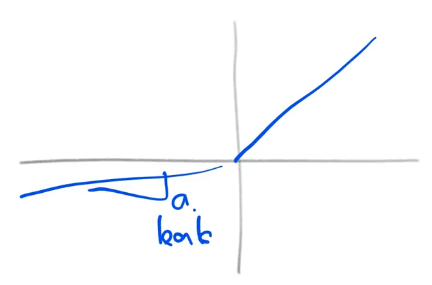

Leaky just means that some value `a` is equal to the slope of the negative numbers from `-inf -> 0`

But since we are working with a conv layer, instead it is just a straight line so our leak (`a`) is 1 effectively

In [28]:
from torch.nn import init

In [29]:
init.kaiming_normal_(l1.weight, a=1.) # Because no ReLU
stats(l1(x))

(tensor(0.0498, grad_fn=<MeanBackward0>),
 tensor(1.1067, grad_fn=<StdBackward0>))

Kaiming got us close to 0,1. and seems to be working quite well. What happens when we use leaky relu

In [30]:
import torch.nn.functional as F

In [31]:
def f1(x, a=0.): return F.leaky_relu(l1(x), a)

In [32]:
init.kaiming_normal_(l1.weight, a=0)
stats(f1(x))

(tensor(0.5116, grad_fn=<MeanBackward0>),
 tensor(0.8894, grad_fn=<StdBackward0>))

While leaky relu with the default keeps the std at 1, our mean is now half due to getting rid of half the values (those in negative).

What happens if we use the torch default?

In [33]:
l1 = nn.Conv2d(1, num_hidden, 5)
stats(f1(x))

(tensor(0.2141, grad_fn=<MeanBackward0>),
 tensor(0.3855, grad_fn=<StdBackward0>))

Our stats are infinitly worse now, no where close to the hoped mean or std.

What happens if we have a varience < 1? 

To get the number of matrix multiplications that occur in a conv layer, we need to multiply the output shape by the filter matrix:

In [34]:
l1.weight.shape

torch.Size([32, 1, 5, 5])

In [35]:
32*5*5 # 800 total matrix multiplications for this individual layer

800

#### Code

In [36]:
receptive_field_size = l1.weight[0,0].numel()
receptive_field_size

25

In [37]:
l1.weight[0,0].shape

torch.Size([5, 5])

#### Explanation

In [38]:
{
    "l1.weight[0,0]": "Grab the first matrix in the conv",
    ".numel()":"Get the total size of that matrix's individual squares",
    "receptive_field_size": "How many elements are in the kernel"
};

In [39]:
num_output_filters, num_input_filters, *_ = l1.weight.shape
num_output_filters, num_input_filters

(32, 1)

In [40]:
fan_in = num_input_filters * receptive_field_size
fan_out = num_output_filters * receptive_field_size
fan_in, fan_out

(25, 800)

In [41]:
def gain(a:float):
    "Calculates the size of the gain during kaiming init"
    return math.sqrt(2. / (1+a**2))

In [42]:
gain(1), gain(0), gain(0.01), gain(0.1), gain(math.sqrt(5))

(1.0,
 1.4142135623730951,
 1.4141428569978354,
 1.4071950894605838,
 0.5773502691896257)

With a slope of 1, the gain is 1 as it's linear. With a slope of < 1, it will approach root 2:

In [43]:
math.sqrt(2)

1.4142135623730951

With sqrt(5) it is far away from the gain we were expecting, which isn't good.

However it doesn't use kaiming normal, it uses kaiming uniform. 

- Key: Blue is normal, Red is uniform

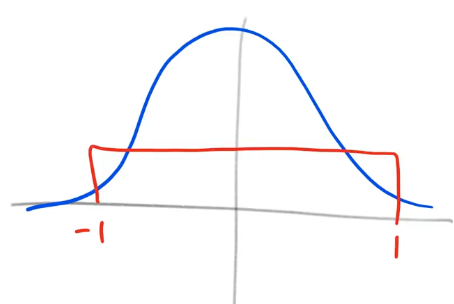

What is the std of a uniform distribution?

In [44]:
import torch
torch.zeros(10_000).uniform_(-1,1).std()

tensor(0.5805)

It's std is .57, or 1/sqrt(3.):

In [45]:
1/math.sqrt(3.)

0.5773502691896258

#### Code

In [46]:
# Refactor into our own
def kaiming_v2(x, a, use_fan_out=False):
    num_out_filters, num_input_filters, *_ = x.shape
    receptive_field_size = x[0,0].shape.numel()
    if use_fan_out:
        fan = num_out_filters * receptive_field_size
    else:
        fan = num_input_filters * receptive_field_size
    std = gain(a) / math.sqrt(fan)
    bound = math.sqrt(3.) * std
    x.data.uniform_(-bound, bound)

#### Explanation

In [47]:
{
    "receptive_field_size = x[0,0].shape.numel()": "Calculate the total squares in our usable matrix",
    "std = gain(a)/math.sqrt(fan)":"Calculate the standard deviation of `a` based on `fan`",
    "bound = math.sqrt(3.) * std": "Given we know it's a uniform distribution, calculate the upper and lower bounds",
    "x.data.uniform_(-bound, bound)": "Apply the newfound bounds to the data inplace"
};

In [48]:
kaiming_v2(l1.weight, a=0)
stats(f1(x))

(tensor(0.5162, grad_fn=<MeanBackward0>),
 tensor(0.8743, grad_fn=<StdBackward0>))

Varience of about 1, and a mean of .5, the expected, What happens if I do it with sqrt(5)?

In [49]:
kaiming_v2(l1.weight, a=5)
stats(f1(x))

(tensor(0.0986, grad_fn=<MeanBackward0>),
 tensor(0.1791, grad_fn=<StdBackward0>))

We'd expect to get the same as the pytorch default, which we have done. But what does this really look like?

In [50]:
class Flatten(nn.Module):
    "A small layer which will flatten `x` by the last axis"
    def forward(self, x): 
        return x.view(-1)

In [51]:
def get_model():
    m = nn.Sequential(
        nn.Conv2d(1,8,5, stride=2, padding=2), nn.ReLU(),
        nn.Conv2d(8,16,3, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(16,32,3, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(32, 1, 3, stride=2, padding=1),
        nn.AdaptiveAvgPool2d(1),
        Flatten()
    )
    return m

m = get_model()

We create a super small test model of 4 conv layers + ReLU with a pooling layer and flattening.

In [52]:
y = y_valid[:100].float() # Grab the labels for our subset of `x`

Next we run it through the whole convnet and take the stats of our result:

In [53]:
t = m(x)
stats(t)

(tensor(0.0161, grad_fn=<MeanBackward0>),
 tensor(0.0103, grad_fn=<StdBackward0>))

When using the default PyTorch init, the varience is almost 0. The first layer and last layers now have a huge difference.

In [54]:
loss = mse(t,y)
loss.backward()

In [55]:
stats(m[0].weight.grad)

(tensor(-0.0114), tensor(0.0453))

Post backward, std of the weights is still nowhere near one.

What happens if we use kaiming uniform?

In [56]:
m = get_model()

#### Code

In [57]:
for layer in m:
    if isinstance(layer, nn.Conv2d):
        init.kaiming_uniform_(layer.weight)
        layer.bias.data.zero_()

#### Explanation

In [58]:
{
    "init.kaiming_uniform_":"If it's a conv layer, initialize with kaiming uniform",
    "layer.bias.data.zero_()":"Afterwards the bias of the data is zeroed out"
};

In [59]:
t = m(x)
stats(t)

(tensor(-0.0386, grad_fn=<MeanBackward0>),
 tensor(0.3797, grad_fn=<StdBackward0>))

It's not terrible, much better than the .001 we had earlier. What happens after the backward?

In [60]:
loss = mse(t,y)
loss.backward()
stats(m[0].weight.grad)

(tensor(-0.1251), tensor(0.6223))

Are stats are now doing much better than before, with a mean of 0 and a std approaching .5 much more.

From here, read [This Notebook](https://muellerzr.github.io/fastai-2019-pt2-notes/why_good_init) and come back

## To twitter we go

Jeremy pinged on twitter asking why this exists. Soumith Chintala answered that this was a historical accident that was never published, but was always in the torch code for the last ~15 years as it was deemed a good bug.

After Jeremy pointed out the issue, the torch team opened an issue to fix it. 

Moral of the story:

> Don't blindly trust a popular library's thing, ask questions and run analysis. It could be a bug that's negatively impacting performance without realizing it